# Generate Inputs for MCOE Calculations
One of the main things that we're building PUDL to do initially is enable the calculation of a marginal cost of electricity (MCOE) for the individual generators within plants. To do this, we need to bring together information from both FERC Form 1 and the EIA Form 923.

Given a target utility, we want to extract and summarize the following information, required to calculate the MCOE on a per plant and per generating unit basis:

* Generator capacities.
* Annual historical generation (in MWh) by each generator.
* Annual historical capacity factor for each generator.
* Annual historical heat rate (mmBTU/MWh) for each generator.
* Annual historical fuel costs per unit generation (\$/MWh) for each generator.
* Annual historical non-fuel production costs (\$/MWh) for each generator.
* Annual historical variable O&M costs (\$/MWh) for each generator.
* Annual historical fixed O&M costs by generator.

Some of these can be extracted directly from the tables we have, some will need to be calculated, and some will be our best estimates or inferrences.

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
from pudl import analysis
import numpy as np
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload
pudl_engine = pudl.db_connect_pudl()

# Where does this data live?
PUDL DB tables that hold the information we're looking for:

### Cost Data:
* Cost of Fuel Delivered: `fuel_receipts_costs_eia923` and `fuel_ferc1`
* Non-Fuel Production Costs: `plants_steam_ferc1`
* Variable O&M Costs: `plants_steam_ferc1`
* Fixed O&M Costs: `plants_steam_ferc1`

### Generation Data:
* Annual Generation by Plant: `plants_steam_ferc1` and `generation_eia923`
* Monthly Generation by Unit: `generation_eia923`

### Fuel Use Data:
* Monthly Fuel Consumed by Unit: `generation_fuel_eia923`
* Annual Fuel Consumed by Plant: `fuel_ferc1`

### Capacity Data:
* Nameplate Capacity by Plant: `plants_steam_ferc1` and `plant_info_eia923`

In [33]:
# These IDs can be generated from each other based on the glue tables. But for now, let's assume that we know them.
PSCo_eia_id = 15466
PSCo_ferc_id = 145

# Extracting FERC Form 1 Fuel & Large Plant Data
We're going to pull information about a respondent, their large steam plants, and the fuel usage at those plants into a single dataframe for analysis.  Mostly what we are doing here is associating all the various IDs (FERC, EIA, PUDL) that we have, with the plant-by-plant data that we're interested in looking at from FERC.  This will allow us to select just the information that we're ultimately interested in, based on many different identifying criteria, and join it with information pulled from the EIA923 datasets.

In [13]:
pudl_tables = models.PUDLBase.metadata.tables
utilities_ferc1 = pudl_tables['utilities_ferc1']
utilities_eia923 = pudl_tables['utilities_eia923']
plants_ferc1 = pudl_tables['plants_ferc1']
plants_eia923 = pudl_tables['plants_eia923']
plants_pudl = pudl_tables['plants']
util_plant_assn = pudl_tables['util_plant_assn']
frc_eia923 = pudl_tables['fuel_receipts_costs_eia923']
gf_eia923 = pudl_tables['generation_fuel_eia923']
fuel_ferc1 = pudl_tables['fuel_ferc1']
steam_ferc1 = pudl_tables['plants_steam_ferc1']

In [5]:
def get_fuel_ferc1_df():
    fuel_ferc1_select = sa.sql.select([
        fuel_ferc1.c.report_year,
        utilities_ferc1.c.respondent_id,
        utilities_eia923.c.operator_id,
        utilities_ferc1.c.util_id_pudl,
        utilities_ferc1.c.respondent_name,
        plants_ferc1.c.plant_id_pudl,
        plants_eia923.c.plant_id,
        fuel_ferc1.c.plant_name,
        fuel_ferc1.c.fuel,
        fuel_ferc1.c.fuel_qty_burned,
        fuel_ferc1.c.fuel_avg_mmbtu_per_unit,
        fuel_ferc1.c.fuel_cost_per_unit_burned,
        fuel_ferc1.c.fuel_cost_per_unit_delivered,
        fuel_ferc1.c.fuel_cost_per_mmbtu,
        fuel_ferc1.c.fuel_cost_per_mwh,
        fuel_ferc1.c.fuel_mmbtu_per_mwh]).\
        where(sa.sql.and_(
            utilities_ferc1.c.respondent_id == fuel_ferc1.c.respondent_id,
            plants_ferc1.c.respondent_id == fuel_ferc1.c.respondent_id,
            plants_ferc1.c.plant_name == fuel_ferc1.c.plant_name,
            utilities_eia923.c.util_id_pudl == utilities_ferc1.c.util_id_pudl,
            plants_eia923.c.plant_id_pudl == plants_ferc1.c.plant_id_pudl))

    return(pd.read_sql(fuel_ferc1_select, pudl_engine))
fuel_df = get_fuel_ferc1_df()

In [11]:
def get_steam_ferc1_df():
    steam_ferc1_select = sa.sql.select([
        steam_ferc1.c.report_year,
        utilities_ferc1.c.respondent_id,
        utilities_eia923.c.operator_id,
        utilities_ferc1.c.util_id_pudl,
        utilities_ferc1.c.respondent_name,
        plants_ferc1.c.plant_id_pudl,
        plants_eia923.c.plant_id,
        steam_ferc1.c.plant_name,
        steam_ferc1.c.total_capacity_mw,
        steam_ferc1.c.net_generation_mwh,
        steam_ferc1.c.expns_operations,
        steam_ferc1.c.expns_fuel,
        steam_ferc1.c.expns_coolants,
        steam_ferc1.c.expns_steam,
        steam_ferc1.c.expns_steam_other,
        steam_ferc1.c.expns_transfer,
        steam_ferc1.c.expns_electric,
        steam_ferc1.c.expns_misc_power,
        steam_ferc1.c.expns_rents,
        steam_ferc1.c.expns_allowances,
        steam_ferc1.c.expns_engineering,
        steam_ferc1.c.expns_structures,
        steam_ferc1.c.expns_boiler,
        steam_ferc1.c.expns_plants,
        steam_ferc1.c.expns_misc_steam,
        steam_ferc1.c.expns_production_total,
        steam_ferc1.c.expns_per_mwh]).\
        where(sa.sql.and_(
            utilities_ferc1.c.respondent_id == steam_ferc1.c.respondent_id,
            plants_ferc1.c.respondent_id == steam_ferc1.c.respondent_id,
            plants_ferc1.c.plant_name == steam_ferc1.c.plant_name,
            utilities_eia923.c.util_id_pudl == utilities_ferc1.c.util_id_pudl,
            plants_eia923.c.plant_id_pudl == plants_ferc1.c.plant_id_pudl
        ))

    return(pd.read_sql(steam_ferc1_select, pudl_engine))
steam_df = get_steam_ferc1_df()

In [26]:
def get_gen_fuel_eia923_df():
    gf_eia923_select = sa.sql.select([
        utilities_eia923.c.operator_id,
        utilities_eia923.c.operator_name,
        plants_eia923.c.plant_id_pudl,
        plants_eia923.c.plant_name,
        gf_eia923.c.plant_id,
        gf_eia923.c.report_date,
        gf_eia923.c.aer_fuel_category,
        gf_eia923.c.fuel_consumed_total_mmbtu,
        gf_eia923.c.net_generation_mwh]).\
        where(sa.sql.and_(
            plants_eia923.c.plant_id == gf_eia923.c.plant_id,
            util_plant_assn.c.plant_id == plants_eia923.c.plant_id_pudl,
            util_plant_assn.c.utility_id == utilities_eia923.c.util_id_pudl
        ))
        
    return(pd.read_sql(gf_eia923_select, pudl_engine))
gf_df = get_gen_fuel_eia923_df()

# Comparing FERC & EIA Data
How well can we correlate FERC & EIA Fuel data by plant?  The simplest case, which ought to give us a good indication of how well this can be done, will involve plants with a single generator, rather than conflating a bunch of sub-plants (different generators, more than one unit, etc.)  If the correlations between these simplest plants work well, then we can move on to more complex plants, using the variables which are shared between the two datasets to zip them together.  These shared variables potentially include the following:
- Total heat content of *each* fuel consumed, on an annual basis.
- Total cost of all heat consumed, on an annual basis.
- Total net electricity generated on an annual basis.

Doing this comparison will entail:
- Identifying those PUDL plant which contain only a single unit/boiler/generator/plant in both datasets.
- Calculating the above variables for each plant.
- Calculating the correlation between each of these variables for each plant, across the years 2009-2015.
- Creating a histogram of the per-plant correlations to see whether there is broad per-plant agreement.
- Calculating the correlation between each of these variables for all plant-year samples in the dataset.
- Creating a scatterplot showing the populations of all plant-year samples (should lie near the 1:1 line)

In [34]:
def get_simple_pudl_plants():
    """Find and return all PUDL plant_id values associated with a
    single FERC plant and a single EIA plant."""
    # We have three lists of plants: PUDL, FERC, and EIA.  Any PUDL plant ID
    # which only appears in all of those lists one time is a "simple" PUDL plant.
    
    ferc1_plant_ids = pd.read_sql('''SELECT plant_id_pudl FROM plants_ferc1''', pudl_engine)
    ferc1_simple_plant_ids = ferc1_plant_ids.drop_duplicates('plant_id_pudl', keep=False)
    eia923_plant_ids = pd.read_sql('''SELECT plant_id_pudl FROM plants_eia923''', pudl_engine)
    eia923_simple_plant_ids = eia923_plant_ids.drop_duplicates('plant_id_pudl', keep=False)
    pudl_simple_plant_ids = np.intersect1d(ferc1_simple_plant_ids['plant_id_pudl'],
                                           eia923_simple_plant_ids['plant_id_pudl'])
    return(pudl_simple_plant_ids)

In [95]:
def pudl_plant_fuel_consumed(pudl_plant_ids,
                             fuels=['gas','oil','coal'],
                             years=range(2009,2016)):
    """Calculate total annual fuel consumption for a list of PUDL plants.
    For each pudl_plant_id provided, calculate the total heat content of fuel
    consumed, for each specified type of fuel, in each of the specified years.
    Do separate tallies based on the EIA923 and FERC1 datasets.
    
    Dataframe Fields:
    - pudl_plant_id
    - year
    - fuel
    - mmbtu_consumed_eia923
    - mmbtu_consumed_ferc1
    """
    gf_totals_df = gen_fuel_by_pudl(pudl_plant_ids, fuels=fuels, years=years)
    gf_totals_df = 
    
    # Get all the FERC info from a fuel_ferc1 & steam_ferc1
    fuel_df = get_fuel_ferc1_df()
    fuel_df = fuel_df[fuel_df.plant_id_pudl.isin(pudl_plant_ids)]
    steam_df = get_steam_ferc1_df()
    steam_df = steam_df[steam_df.plant_id_pudl.isin(pudl_plant_ids)]
    

In [101]:
def gen_fuel_by_pudl(pudl_plant_ids, fuels=['gas','oil','coal'], years=[2009,2010,2011,2012,2013,2014,2015]):
    # Get all the EIA info from generation_fuel_eia923
    gf_df = get_gen_fuel_eia923_df()
    
    # Select only the records in these dataframes that pertain to our target IDs
    gf_df = gf_df[gf_df.plant_id_pudl.isin(pudl_plant_ids)]
    
    # Set the DF up for grouping
    gf_df['report_date'] = pd.to_datetime(gf_df['report_date'])
    gf_df.index = gf_df.report_date
    gf_df = gf_df.rename(columns={'aer_fuel_category':'fuel'})
    # Group EIA by year, fuel, pudl_plant_id
    gf_gb = gf_df.groupby(by=[pd.TimeGrouper(freq='A'),'fuel','plant_id_pudl'])
    gf_totals = gf_gb[['fuel_consumed_total_mmbtu','net_generation_mwh']].sum()
    gf_totals_df = pd.DataFrame(gf_totals).reset_index()
    gf_totals_df['fuel'] = gf_totals_df.fuel.replace(to_replace='petroleum', value='oil')
    gf_totals_df['report_year'] = gf_totals_df['report_date'].dt.year
    gf_totals_df = gf_totals_df[gf_totals_df['fuel'].isin(fuels)]
    gf_totals_df = gf_totals_df[['plant_id_pudl','report_year','fuel','fuel_consumed_total_mmbtu','net_generation_mwh']]
    return(gf_totals_df)

In [98]:
simple_plants = get_simple_pudl_plants()
# Okay this seems to work... at least approximately.
# gf_totals_df = pudl_plant_fuel_consumed(simple_plants)

fuel_df = get_fuel_ferc1_df()
fuel_df = fuel_df[fuel_df.plant_id_pudl.isin(simple_plants)]

steam_df = get_steam_ferc1_df()
steam_df = steam_df[steam_df.plant_id_pudl.isin(simple_plants)]

In [100]:
fuels = ['coal','oil','gas']
fuel_df['fuel_consumed_total_mmbtu'] = fuel_df['fuel_qty_burned'] * fuel_df['fuel_avg_mmbtu_per_unit']
fuel_df['fuel_consumed_total_cost_mmbtu'] = fuel_df['fuel_cost_per_mmbtu'] * fuel_df['fuel_consumed_total_mmbtu']
fuel_df['fuel_consumed_total_cost_unit'] = fuel_df['fuel_qty_burned'] * fuel_df['fuel_cost_per_unit_burned']
fuel_cols = ['plant_id_pudl', 'report_year', 'fuel',
             'fuel_consumed_total_mmbtu',
             'fuel_consumed_total_cost_mmbtu',
             'fuel_consumed_total_cost_unit']
fuel_df = fuel_df[fuel_cols]
fuel_df = fuel_df[fuel_df['fuel'].isin(fuels)]

steam_cols = ['plant_id_pudl, util_id_pudl', 'report_year',
              'net_generation_mwh','expns_fuel',]

Index(['report_year', 'respondent_id', 'operator_id', 'util_id_pudl',
       'respondent_name', 'plant_id_pudl', 'plant_id', 'plant_name',
       'total_capacity_mw', 'net_generation_mwh', 'expns_operations',
       'expns_fuel', 'expns_coolants', 'expns_steam', 'expns_steam_other',
       'expns_transfer', 'expns_electric', 'expns_misc_power', 'expns_rents',
       'expns_allowances', 'expns_engineering', 'expns_structures',
       'expns_boiler', 'expns_plants', 'expns_misc_steam',
       'expns_production_total', 'expns_per_mwh'],
      dtype='object')

In [70]:
# Group EIA by year, fuel, pudl_plant_id
gf_gb = gf_df.groupby(['plant_id_pudl', pd.TimeGrouper(freq='A'), 'aer_fuel_category'])
gf_totals = gf_gb[['fuel_consumed_total_mmbtu','net_generation_mwh']].sum()

In [92]:
gf_totals_df = pd.DataFrame(gf_totals).reset_index()
gf_totals_df['report_year'] = gf_totals_df['report_date'].dt.year
gf_totals_df = gf_totals_df[gf_totals_df['aer_fuel_category'].isin(['coal','petroleum','gas'])]
gf_totals_df = gf_totals_df.rename(columns={'aer_fuel_category':'fuel'})
gf_totals_df = gf_totals_df[['plant_id_pudl','report_year','fuel','fuel_consumed_total_mmbtu','net_generation_mwh']]
gf_totals_df['fuel'] = gf_totals_df.fuel.replace(to_replace='petroleum', value='oil')
gf_totals_df

,plant_id_pudl,report_year,fuel,fuel_consumed_total_mmbtu,net_generation_mwh
0,2,2009,coal,29325112.0,2821627.303
1,2,2009,oil,69110.0,6586.697
2,2,2010,coal,36800393.0,3588709.254
3,2,2010,oil,48374.0,4723.746
4,2,2011,coal,38824123.0,3784789.780
5,2,2011,oil,20561.0,2005.231
6,2,2012,coal,39696028.0,3788953.830
7,2,2012,oil,22338.0,2139.168
8,2,2013,coal,32683434.0,3061411.406
9,2,2013,oil,49539.0,4637.594


# Bringing the Fuel & Plant Data Together
Now that we have the relevant plant (steam) and fuel consumption data pulled, along with all of the various IDs, we need to aggregate some of the data by plant and by year. First of all, many of the plants have multiple fuels reported, but we are primarily interested in the aggregate of their expenses, and production based on total heat content.

### Variables to report by year on a per plant basis:
0. Net electricity generated (MWh).
0. Total heat content of fuel consumed (mmBTU).
0. Heat content of fuel consumed per unit of net generation (mmBTU/MWh).
0. Capacity Factor (as a fraction).
0. Fuel cost per unit of net generation ($/MWh).
0. Non-fuel production cost per unit of net generation ($/MWh).
0. Non-production costs per unit of plant capacity ($/MW).
0. Non-production costs per unit of net generation ($/MWh).

Because multiple FERC respondents report information about shared plants, we need to select a particular respondent in order to ensure that we don't get duplicate information.

In [6]:
fuel_df['total_mmbtu'] = fuel_df['fuel_qty_burned']*fuel_df['fuel_avg_mmbtu_per_unit']
fuel_df['total_fuel_cost_mmbtu'] = fuel_df['fuel_cost_per_mmbtu']*fuel_df['total_mmbtu']
fuel_df['total_fuel_cost_units'] = fuel_df['fuel_cost_per_unit_burned']*fuel_df['fuel_qty_burned']

### Sanity check...
We ought to be able to calculate the total fuel cost here in two different ways, and get the same value -- one based on the number of fuel units consumed, and another based on the total heat content of the fuel consumed. Let's plot it and see how good the data really is.

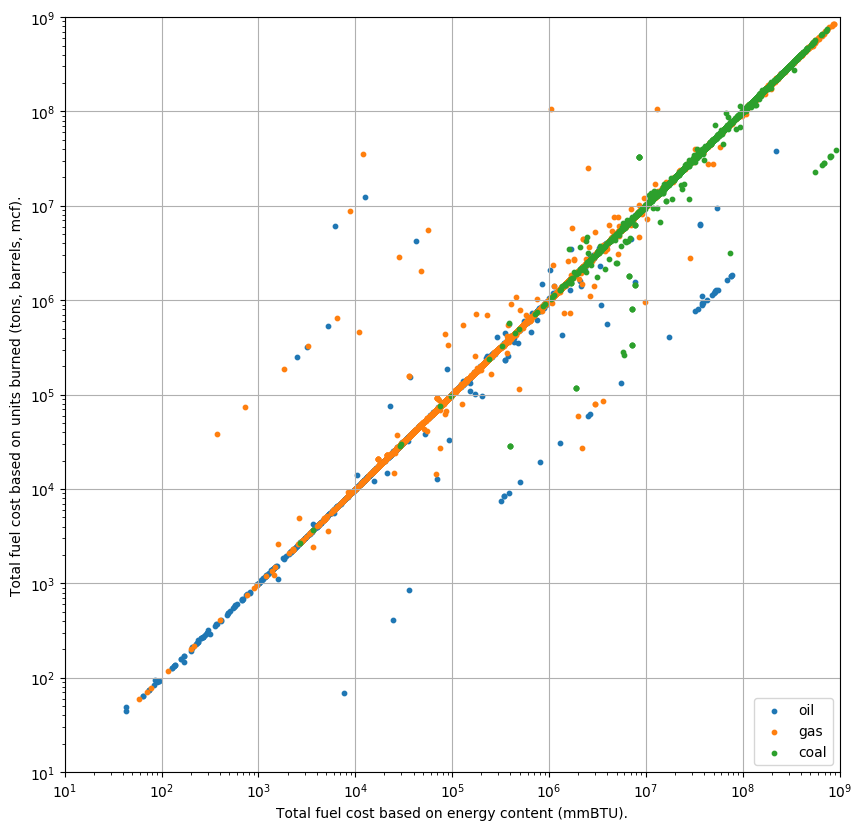

In [7]:
fuel_df['total_mmbtu'] = fuel_df['fuel_qty_burned']*fuel_df['fuel_avg_mmbtu_per_unit']
fuel_df['total_fuel_cost_mmbtu'] = fuel_df['fuel_cost_per_mmbtu']*fuel_df['total_mmbtu']
fuel_df['total_fuel_cost_units'] = fuel_df['fuel_cost_per_unit_burned']*fuel_df['fuel_qty_burned']
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(100)
ax.loglog()
plt.ylim(10,1e9)
plt.xlim(10,1e9)
plt.grid()
target=145 # PSCo
#target=134 # PacifiCorp
#target=133 # PG&E
for fuel in ['oil','gas','coal']:
#    ax.scatter(fuel_df[(fuel_df.fuel==fuel) & (fuel_df.respondent_id==target)]['total_fuel_cost_mmbtu'],
#               fuel_df[(fuel_df.fuel==fuel) & (fuel_df.respondent_id==target)]['total_fuel_cost_units'],
#               label=fuel, s=10)
    ax.scatter(fuel_df[(fuel_df.fuel==fuel)]['total_fuel_cost_mmbtu'],
               fuel_df[(fuel_df.fuel==fuel)]['total_fuel_cost_units'],
               label=fuel, s=10)
ax.legend(loc='lower right')
plt.ylabel("Total fuel cost based on units burned (tons, barrels, mcf).")
plt.xlabel("Total fuel cost based on energy content (mmBTU).")

In [8]:
# These are useful fields shared by fuel and plant dataframes:
ferc_merge_fields = ['report_year',
                     'respondent_id',
                     'operator_id',
                     'util_id_pudl',
                     'respondent_name',
                     'plant_id_pudl',
                     'plant_id',
                     'plant_name']

index_cols = ['util_id_pudl','plant_id_pudl','report_year']

ferc_merge = fuel_df[ferc_merge_fields].copy()
ferc_merge = ferc_merge.drop_duplicates(subset=index_cols)

fuel_by_plant_year = fuel_df.groupby(index_cols)

# Fields we want to pull in from the fuel dataframe, by plant_id_pudl
fuel_merge_fields = ['total_mmbtu',
                     'total_fuel_cost_units',
                     'total_fuel_cost_mmbtu']

for field in fuel_merge_fields:
    ferc_merge = ferc_merge.merge(pd.DataFrame(fuel_by_plant_year[field].sum()),
                                  left_on=index_cols,
                                  right_index=True)

# Fields we're ultimately trying to get from the steam dataframe:
steam_merge_fields = ['total_capacity_mw',
                      'net_generation_mwh',
                      'expns_fuel',
                      'expns_nonfuel_production',
                      'expns_nonproduction']

# But first we need to calculate the non-fuel production and non-production expenses:
expns_corr = analysis.ferc1_expns_corr(pudl_engine, capacity_factor=0.6)

steam_bad_cols = ['expns_fuel', 'expns_per_mwh','expns_production_total']
# Remove the expns_* columns that we don't want to aggregate
for key in steam_bad_cols:
    x = expns_corr.pop(key, None)
    
# For now using correlation with net_generation > 0.5 as indication of "production" vs. non-produciton
expns_nonfuel_production = [k for k in expns_corr.keys() if expns_corr[k] >= 0.5]
expns_nonproduction = [k for k in expns_corr.keys() if expns_corr[k] < 0.5]

steam_df['expns_nonfuel_production'] = steam_df[expns_nonfuel_production].copy().sum(axis=1)
steam_df['expns_nonproduction'] = steam_df[expns_nonproduction].copy().sum(axis=1)
    
steam_by_plant_year = steam_df.groupby(index_cols)

for field in steam_merge_fields:
    ferc_merge = ferc_merge.merge(pd.DataFrame(steam_by_plant_year[field].sum()),
                                  left_on=index_cols,
                                  right_index=True)

In [9]:
ferc_merge['expns_fuel_per_mwh'] = ferc_merge['expns_fuel'] / ferc_merge['net_generation_mwh']
ferc_merge['expns_nonfuel_production_per_mwh'] = ferc_merge['expns_nonfuel_production'] / ferc_merge['net_generation_mwh']
ferc_merge['expns_nonproduction_per_mwh'] = ferc_merge['expns_nonproduction'] / ferc_merge['net_generation_mwh']
ferc_merge['expns_nonproduction_per_mw'] = ferc_merge['expns_nonproduction'] / ferc_merge['total_capacity_mw']
ferc_merge['mmbtu_per_mwh'] = ferc_merge['total_mmbtu'] / ferc_merge['net_generation_mwh']
ferc_merge['capacity_factor'] = ferc_merge['net_generation_mwh'] / (8760 * ferc_merge['total_capacity_mw'])

In [28]:
fuel_df[fuel_df['plant_id_pudl']==627]

,report_year,respondent_id,operator_id,util_id_pudl,respondent_name,plant_id_pudl,plant_id,plant_name,fuel,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh,total_mmbtu,total_fuel_cost_mmbtu,total_fuel_cost_units
484,2007,145,15466,272,Public Service Company of Colorado,627,477,Valmont 5,coal,542519.0,22.938,42.016,42.016,1.832,18.0,9.522258,1.244430e+07,2.279796e+07,2.279448e+07
485,2007,145,15466,272,Public Service Company of Colorado,627,55207,Valmont 5,coal,542519.0,22.938,42.016,42.016,1.832,18.0,9.522258,1.244430e+07,2.279796e+07,2.279448e+07
486,2007,145,15466,272,Public Service Company of Colorado,627,477,Valmont 5,gas,295825.0,0.891,3.570,3.570,4.000,0.0,0.000000,2.635801e+05,1.054320e+06,1.056095e+06
487,2007,145,15466,272,Public Service Company of Colorado,627,55207,Valmont 5,gas,295825.0,0.891,3.570,3.570,4.000,0.0,0.000000,2.635801e+05,1.054320e+06,1.056095e+06
495,2007,145,15466,272,Public Service Company of Colorado,627,477,Valmont 6,gas,91507.0,0.892,4.950,4.950,5.550,77.0,13.791244,8.162424e+04,4.530146e+05,4.529597e+05
496,2007,145,15466,272,Public Service Company of Colorado,627,55207,Valmont 6,gas,91507.0,0.892,4.950,4.950,5.550,77.0,13.791244,8.162424e+04,4.530146e+05,4.529597e+05
1707,2008,145,15466,272,Public Service Company of Colorado,627,477,Valmont 5,coal,490724.0,23.948,47.370,47.370,1.979,20.0,9.946180,1.175186e+07,2.325693e+07,2.324560e+07
1708,2008,145,15466,272,Public Service Company of Colorado,627,55207,Valmont 5,coal,490724.0,23.948,47.370,47.370,1.979,20.0,9.946180,1.175186e+07,2.325693e+07,2.324560e+07
1709,2008,145,15466,272,Public Service Company of Colorado,627,477,Valmont 5,gas,30876.0,0.992,10.170,10.170,10.250,0.0,0.000000,3.062899e+04,3.139472e+05,3.140089e+05
1710,2008,145,15466,272,Public Service Company of Colorado,627,55207,Valmont 5,gas,30876.0,0.992,10.170,10.170,10.250,0.0,0.000000,3.062899e+04,3.139472e+05,3.140089e+05


In [11]:
frc_eia923_select = sa.sql.select([
    utilities_eia923.c.util_id_pudl,
    utilities_eia923.c.operator_id,
    utilities_eia923.c.operator_name,
    plants_eia923.c.plant_id_pudl,
    plants_eia923.c.plant_id,
    plants_eia923.c.plant_name,
    frc_eia923.c.report_date,
    frc_eia923.c.energy_source,
    frc_eia923.c.fuel_group,
    frc_eia923.c.fuel_quantity,
    frc_eia923.c.average_heat_content,
    frc_eia923.c.fuel_cost
    ]).\
    where(sa.sql.and_(
        plants_eia923.c.plant_id == frc_eia923.c.plant_id,
        util_plant_assn.c.plant_id == plants_eia923.c.plant_id_pudl,
        util_plant_assn.c.utility_id == utilities_eia923.c.util_id_pudl
    ))
    
frc_df = pd.read_sql(frc_eia923_select, pudl_engine)

#frc_df = pd.read_sql('''SELECT * FROM fuel_receipts_costs_eia923''', pudl_engine)
#frc_df[frc_df['plant_id']==477]

In [ ]:
gf_df = pd.read_sql('''SELECT * FROM generation_fuel_eia923''', pudl_engine)

In [27]:
frc_df[frc_df['plant_name'].str.contains('almont')]

,util_id_pudl,operator_id,operator_name,plant_id_pudl,plant_id,plant_name,report_date,energy_source,fuel_group,fuel_quantity,average_heat_content,fuel_cost
365,373,58164,"180 Raritan Energy Solutions, LLC",627,477,Valmont,2009-01-01,NG,Natural Gas,4181.0,1.000,623.0
366,3386,1415,SWG Colorado LLC,627,477,Valmont,2009-01-01,NG,Natural Gas,4181.0,1.000,623.0
367,272,15466,Public Service Co of Colorado,627,477,Valmont,2009-01-01,NG,Natural Gas,4181.0,1.000,623.0
368,373,58164,"180 Raritan Energy Solutions, LLC",627,477,Valmont,2009-01-01,NG,Natural Gas,2772.0,1.000,592.7
369,3386,1415,SWG Colorado LLC,627,477,Valmont,2009-01-01,NG,Natural Gas,2772.0,1.000,592.7
370,272,15466,Public Service Co of Colorado,627,477,Valmont,2009-01-01,NG,Natural Gas,2772.0,1.000,592.7
371,373,58164,"180 Raritan Energy Solutions, LLC",627,477,Valmont,2009-01-01,SUB,Coal,36064.0,17.762,155.4
372,3386,1415,SWG Colorado LLC,627,477,Valmont,2009-01-01,SUB,Coal,36064.0,17.762,155.4
373,272,15466,Public Service Co of Colorado,627,477,Valmont,2009-01-01,SUB,Coal,36064.0,17.762,155.4
8320,373,58164,"180 Raritan Energy Solutions, LLC",627,55207,Valmont Combustion Turbine Project,2009-01-01,NG,Natural Gas,7958.0,0.995,NaN


In [13]:
craig_frc = frc_df[frc_df['plant_name']=='Craig (CO)']
len(craig_frc[craig_frc['operator_id']==15466])

487

In [14]:
plants_eia923_df = pd.read_sql('''SELECT * FROM plants_eia923''', pudl_engine)

In [15]:
fuel_df[fuel_df['plant_name'].str.contains('almont')][['report_year','plant_name','fuel','total_mmbtu']]

,report_year,plant_name,fuel,total_mmbtu
484,2007,Valmont 5,coal,1.244430e+07
485,2007,Valmont 5,coal,1.244430e+07
486,2007,Valmont 5,gas,2.635801e+05
487,2007,Valmont 5,gas,2.635801e+05
495,2007,Valmont 6,gas,8.162424e+04
496,2007,Valmont 6,gas,8.162424e+04
1707,2008,Valmont 5,coal,1.175186e+07
1708,2008,Valmont 5,coal,1.175186e+07
1709,2008,Valmont 5,gas,3.062899e+04
1710,2008,Valmont 5,gas,3.062899e+04


In [16]:
plants_eia923_df[plants_eia923_df['plant_name'].str.contains('almont')]
frc_df[frc_df['plant_id'].isin([477,55207])][['plant_id','report_date','fuel_group','fuel_quantity','average_heat_content']]

,plant_id,report_date,fuel_group,fuel_quantity,average_heat_content
365,477,2009-01-01,Natural Gas,4181.0,1.000
366,477,2009-01-01,Natural Gas,4181.0,1.000
367,477,2009-01-01,Natural Gas,4181.0,1.000
368,477,2009-01-01,Natural Gas,2772.0,1.000
369,477,2009-01-01,Natural Gas,2772.0,1.000
370,477,2009-01-01,Natural Gas,2772.0,1.000
371,477,2009-01-01,Coal,36064.0,17.762
372,477,2009-01-01,Coal,36064.0,17.762
373,477,2009-01-01,Coal,36064.0,17.762
8320,55207,2009-01-01,Natural Gas,7958.0,0.995


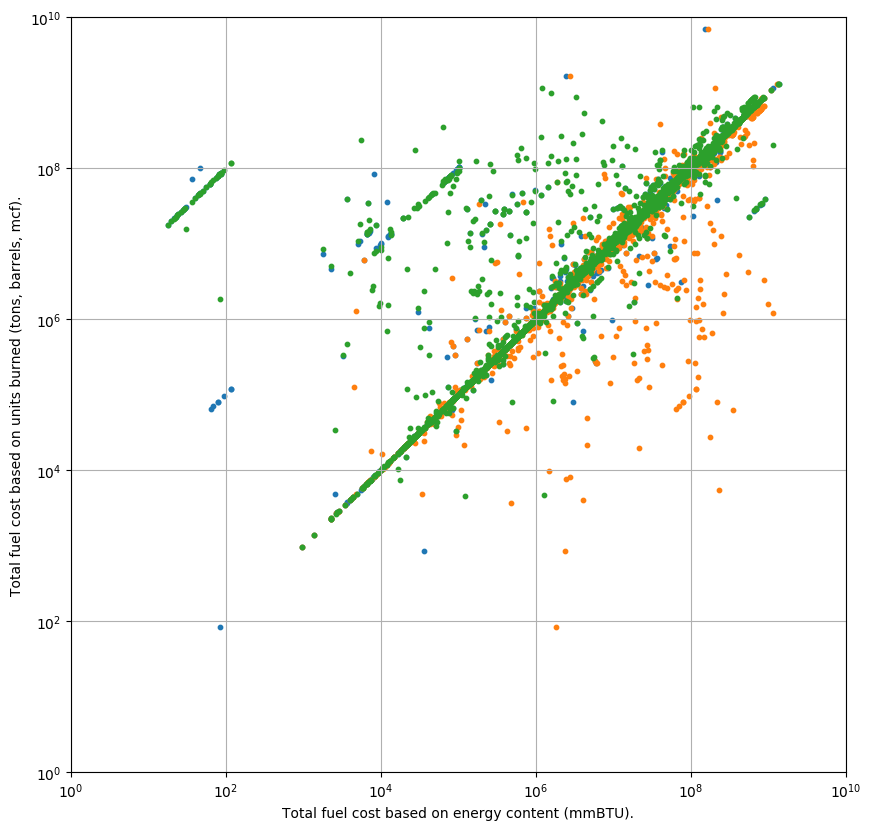

In [17]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(100)
ax.loglog()
plt.ylim(1,1e10)
plt.xlim(1,1e10)
plt.grid()
target=145 # PSCo
#target=134 # PacifiCorp
#target=133 # PG&E
#    ax.scatter(fuel_df[(fuel_df.fuel==fuel) & (fuel_df.respondent_id==target)]['total_fuel_cost_mmbtu'],
#               fuel_df[(fuel_df.fuel==fuel) & (fuel_df.respondent_id==target)]['total_fuel_cost_units'],
#               label=fuel, s=10)
ax.scatter(ferc_merge['total_fuel_cost_mmbtu'],
           ferc_merge['total_fuel_cost_units'],
           s=10)
ax.scatter(ferc_merge['expns_fuel'],
           ferc_merge['total_fuel_cost_units'],
           s=10)
ax.scatter(ferc_merge['total_fuel_cost_mmbtu'],
           ferc_merge['expns_fuel'],
           s=10)
plt.ylabel("Total fuel cost based on units burned (tons, barrels, mcf).")
plt.xlabel("Total fuel cost based on energy content (mmBTU).")

In [18]:
cap_fac = ferc_merge[ferc_merge['capacity_factor'].apply(np.isfinite)]['capacity_factor']

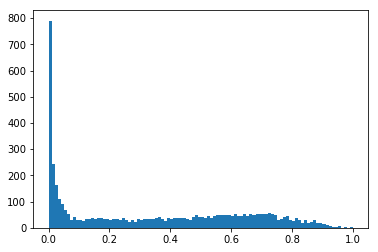

In [19]:
fig = plt.hist(cap_fac, bins=100, range=(0,1))

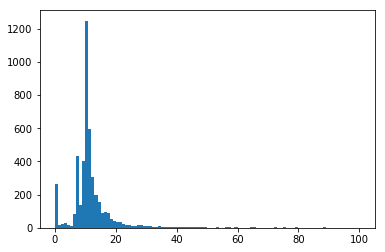

In [20]:
fig = plt.hist(ferc_merge['mmbtu_per_mwh'], bins=100, range=(0,100))

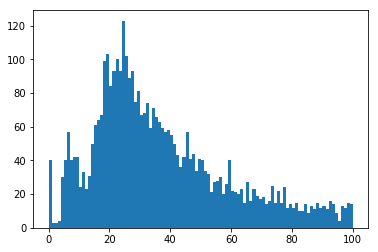

In [21]:
fig = plt.hist(ferc_merge['expns_fuel_per_mwh'], bins=100, range=(0,100))

In [22]:
ferc_merge['expns_total'] = ferc_merge['expns_fuel'] + \
                            ferc_merge['expns_nonfuel_production'] + \
                            ferc_merge['expns_nonproduction']

In [23]:
ferc_merge['expns_total_per_mwh'] = ferc_merge['expns_total'] / ferc_merge['net_generation_mwh']

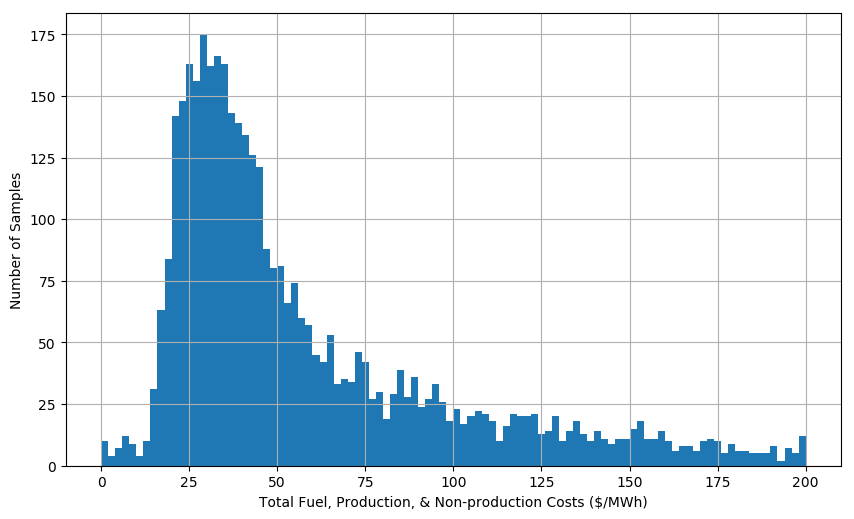

In [24]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(6)
fig.set_dpi(100)
plt.grid()
ax.set_ylabel("Number of Samples")
ax.set_xlabel("Total Fuel, Production, & Non-production Costs ($/MWh)")
x = ax.hist(ferc_merge['expns_total_per_mwh'], bins=100, range=(0,200))

In [25]:
sa.__version__

'1.1.9'